Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Weronika Pawlak"

---

In [2]:
import pickle

import numpy as np
from scipy.stats import boxcox
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression
import torch

In [3]:
import sys
sys.path.append('./')

from src.visualization import (
    plot_data,
    plot_ols,
)

from src.utils import (
    make_ols,
)

# Regresja Liniowa - wstęp

Regresja liniowa to model oparty na **liniowej kombinacji parametrów i zmiennych niezależnych** w celu dopasowania do **rzeczywistej zmiennej zależnej**.

Rozważmy prosty przykład na bazie poniższego zbioru danych z jedną zmienną niezależną:
$$ y = f(x) $$

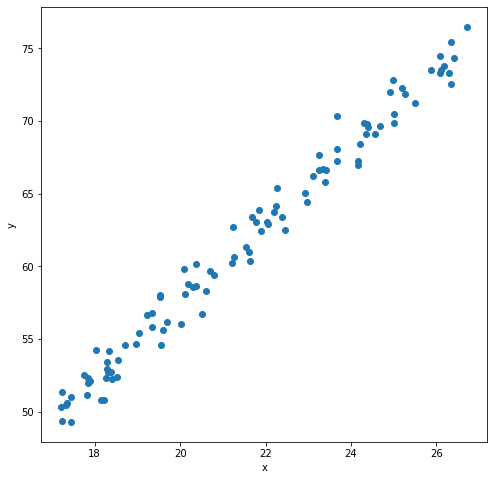

In [4]:
df = pd.read_pickle('./data/artificial_2d.pkl')

plot_data(df, properties={'x': 'x'})

Obserwujemy **liniowy trend**, więc model regresji liniowej jest adekwatny. Dla każdego punktu $i$ w zbiorze danych model wygląda następująco:

$$ y_i = \beta_1 * x_i + \beta_0 + \epsilon_i, $$

gdzie $\beta_1$ to współczynnik/parametr przy jedynej zmiennej niezależnej, a $\beta_0$ to **wyraz wolny** (ang. *intercept term* bądź *bias term*, gdzie ten pierwszy używany jest przez statystyków, a drugi przez ML-owców). Natomiast $\epsilon_i$ odpowiada za **składnik losowy (błąd losowy)** (ang. *disturbance term*, *error variable*) i jest zmienną losową związaną z $i$-tym punktem danych.

Spróbujmy ręcznie dopasować parametry dla tego zbioru danych.

- współczynnik $\beta_1$

   $f(20) \approx 57$ oraz $f(24) \approx 67$, zatem $\hat{\beta}_1 \approx \frac{67-57}{24-20} = 2.5$

- wyraz wolny $\beta_0$

   $f(18) =  \hat{\beta}_1 * 18 + \beta_0 + \epsilon_i \approx 52$, zatem pomijająć składnik losowy mamy $\hat{\beta_0} \approx 52 - 2.5 * 18 = 7$
   
Sprawdźmy tak wyestymowany model!

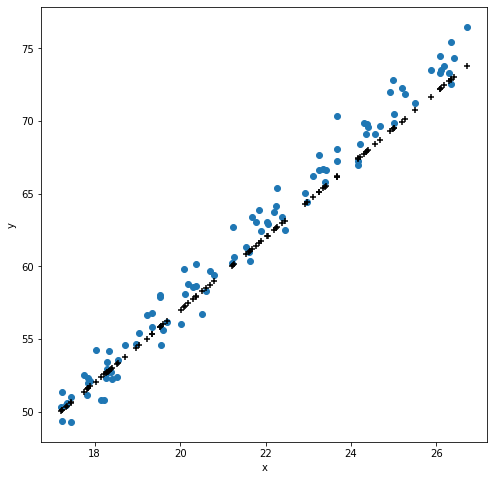

In [5]:
beta = {
    'intercept': 7,
    'x': 2.5,
}

plot_data(df, properties={'x': 'x'}, regression_parameters=beta)

Policzmy jak **średnio** oddalona jest predykowana wartość od prawdziwej - czyli policzmy **błąd średniokwadratowy** (ang. *mean squared error [MSE]*)

In [6]:
((df['x'] * 2.5 + 7 - df['y'])**2).sum() / len(df)

2.0115067951334513

# Regresja Liniowa - formalnie

Niech $X$ to macierz $[N \times (m + 1)]$ zawierająca $m$ zmiennych niezależnych poprzedzonych $1$ (odpowiada za wyraz wolny) dla każdego z $N$ punktów danych. Poprzez $\pmb{x}_i$ oznaczmy wektor $[1 \times (m+1)]$ cech dla $i$-tej instancji, czyli $i$-ty wiersz macierzy $X$. Ponadto poprzez $\pmb{\beta}$ oznaczmy wektor $[(m+1) \times 1]$ rzeczywistych współczynników, czyli parametrów modelu.

$$X = \begin{bmatrix} 
    \pmb{x}_1 \\
    \pmb{x}_2 \\
    \vdots \\
    \pmb{x}_N \\
    \end{bmatrix} =
    \begin{bmatrix} 
    1 & x_{11} & \dots & x_{1m} \\
    1 & x_{21} & \dots & x_{2m} \\
    \vdots & \vdots & \ddots & \vdots \\
    1 & x_{N1} & \dots & x_{Nm} \\
    \end{bmatrix}
$$

Wtedy model regresji liniowej dla każdego punktu danych $i$ to

$$ y_i = \pmb{x}_i \pmb{\beta} + \epsilon_i, $$
gdzie $y_i$ to wartość **zmiennej zależnej**, a $\epsilon_i$ to **zmienna losowa** odpowiadają za **błąd** modelu dla $i$-tej instacji.

Gdy zmienne zależne $y_i$ dla wszystkich punktów danych zbierzemy w macierz $Y$ $[N \times 1]$ (czyli pionowy wektor), oraz ze zmiennych losowych $\epsilon_i$ zbudujemy wektor losowy $\pmb{\epsilon}$, model regresji liniowej możemy zapisać w postaci wektorowej jako

$$ Y = X \pmb{\beta} + \pmb{\epsilon} $$

# Estymacja parametrów - Ordinary Least Squares

Model regresji liniowej jest najczęściej stosowany w dwóch przypadkach:
1. Posiadając pewien zbiór danych historycznych $(X, Y)$ chcemy **estymować parametry** aby dokonywać **predykcji** zmiennej zależnej dla nowych zestawów zmiennych niezależnych. Poczynione jest tutaj kilka założeń:
  * Proces generujący jest **stacjonarny** - nie następuje *concept drift*.
  * Zbiór danych $(X, Y)$ jest reprezentatywny, tzn. że $X$ pokrywa przestrzeń zgodnie z rzeczywistym rozkładem i $Y$ posiada taką wariancję jak rzeczywisty proces.
2. Posiadając zbiór danych $(X, Y)$ chcemy wiedzieć w jaki sposób - wartość, znak **estymowanych parametrów** - zmiennie niezależne wpływają na zmienną zależną.

Podstawowa metoda estymacji parametrów to **Ordinary Least Squares** i jak sama nazwa wskazuje polega na optymalizacji (czyli minimalizacji w tym przypadku) **(średniego) błędu kwadratowego**. Kluczowym jest zauważyć, że przy takim sformułowaniu problemu celem jest dopasowanie **średniej wartości** zwracanej przez model $\mathrm{E}[\pmb{x}_i \pmb{\beta} + \epsilon_i]$. Jedną z konsekwencji jest możliwość wystąpienia w **zbiorze treningowym/uczącym** dwóch instancji o takim samym wektorze $\pmb{x}$ i różnych wartościach $y$.

### Wyprowadzenia estymatorów OLS można dokonać w dwojaki sposób:
- Przekształcenia algebraiczne

   W tym podejściu wprost wyrażona jest chęć dopasowania wartości oczekiwanej $\mathrm{E}[Y]$, co przy założeniu (założenia zostaną omówione w dalszej części zeszytu) że $\mathrm{E}[\epsilon_i] = 0$ oznacza wyeliminowanie czynnika losowego z procesu estymacji - będzie miał on znaczenie dla oceny jakości modelu i dla predykcji.

   $$ X \hat{\pmb{\beta}} = Y$$
   $$ (X^\intercal X) \hat{\pmb{\beta}} = X^\intercal Y $$
   $$ \hat{\pmb{\beta}} = (X^\intercal X)^{-1} X^\intercal Y $$

- Funkcja kosztu + optymalizacja gradientowa w jednym kroku (closed form solution)

   W tym podejściu (bardziej ogólnym i teoretycznie ugruntowanym) rozumowanie przebiega "w przeciwnym kierunku" - skoro wartość oczekiwana błędu wynosi $0$ (zgodnie z założeniami modelu), to odnajdując parametry modelu dające taką "empiryczną wartość oczekiwaną" (czyli estymator wartości oczekiwanej) mamy optymalny model. W konsekwencji model dopasowuje się do średniej. 

   $$ S(\hat{\pmb{\beta}}) = \sum_{i=1}^N \left| y_i - \sum_{j=0}^m x_{ij} \hat{\beta}_j \right|^2 = \left\|Y - X \hat{\pmb{\beta}} \right\|^2 = (Y - X \hat{\pmb{\beta}})^\intercal (Y - X \hat{\pmb{\beta}})$$

   Gdy $m=1$ to klasyczne zadanie na kursie ze statystyki i pokrewnych.
   
   Gdy $m > 1$ to analiza wektorowa i przekształcenia algebraiczne. Oczywiście można "ręcznie" wyprowadzić estymator dla każdego parametru.

Na bazie $\hat{\pmb{\beta}}$ możemy teraz wyprowadzić dwa estymatory $\sigma^2 = \mathrm{Var}[\epsilon_i]$:
- Estymator OLS (nieobciążony):
   $$ s^2 = \frac{Y^\intercal M Y}{N - (m+1)} $$
- Estymator MLE:
   $$ \hat{\sigma}^2 = \frac{Y^\intercal M Y}{N} $$
gdzie $M = (\mathrm{I}_N - X(X^\intercal X)^{-1} X^\intercal)$ to **annihilator matrix** (bo $MX=0$).


### Założenia:
- Liniowa kombinacja zmiennych niezależnych jest procesem generującym zmienną zależną (z dokładnością do losowego czynnika) -- założenie to oczywiście nie jest weryfikowalne i w rzeczywistych zastosowaniach jest najczęściej naruszone.

- Macierz $X$ jest rzędu $m+1$ - $\text{rank}(X) = m+1$ - czyli ma **pełny rząd kolumnowy**.
   Rząd macierzy określa liczbę niezależnych liniowo kolumn (równocześnie wierszy) w macierzy. Gdy macierz układu równań posiada niższy rząd niż liczba kolumn, to możemy powiedzieć że jest zdegenerowana - tą samą przestrzeń można reprezentować za pomocą mniejszej liczby wymiarów. Czyli jedną (bądź więcej) zmienną niezależną można wyrazić jako liniową kombinację pozostałych zmiennych.
   
   Dla OLS jest to duży problem, ponieważ model staje się **non-identifiable**, czyli nie posiada jednego rozwiązania nawet przy nieskończonej liczbie próbek.
   
   Rozważmy sytuację gdy kolumna $X_1 = 2 X_2$. Wtedy dla wyestymowanych współczynników $\beta_1$ i $\beta_2$ możemy zaproponować nieskończenie wiele modeli z parametrami $\beta'_1$ i $\beta'_2$ tak długo, jak $\beta'_1 + 2\beta'_2 = \beta_1 + 2\beta_2$ - dwie niewiadome, jedno równanie -> nieskończenie wiele rozwiązań.
   
   Problem ukazuje się także z perspektywy rozwiązania algebraicznego - jeżeli $X$ nie ma pełnego rzędu, to $X^\intercal X$ nie może być odwrócona.
   
- Strict exogeneity - wektor błędów $\pmb{\epsilon}$ ma warunkową średnią 0

   $$ \mathrm{E}[\pmb{\epsilon} | X] = 0 $$
   
   W konsekwencji również $ \mathrm{E}[\pmb{\epsilon}] = 0 $ (skorzystaliśmy z tego podczas wyprowadzania OLS), a także zmienne niezależne nie są skorelowane z błędami: $ \mathrm{E}[X^\intercal \pmb{\epsilon}] = 0 $.

- Nieskorelowane błędy o stałej wariancji - $ \mathrm{Var}[\pmb{\epsilon} | X] = \sigma^2 \mathrm{I}_N$. Wartość parametru $\sigma^2$ nie jest niezbędna dla OLS, ale potrzebna dla wyznaczenia przedziałów ufności i przedziałów predykcyjnych (więcej o tym później).

   To założenie często jest rozdzielone na dwie części:
     * Homoskedastyczność (ang. *homoscedasticity*) - $\forall_{i \in {1, \ldots, N}} \mathrm{E}[\epsilon_i^2 | X] = \sigma^2$, czyli stała wariancja błędu dla każdego punktu.
     * Brak autokorelacji (ang. *no autocorrelation*) - $\forall_{i, j \in {1, \ldots, N}; i \neq j} \mathrm{E}[\epsilon_i \epsilon_j | X] = 0$. Powszechnie naruszone dla szeregów czasowych, dlatego rozwinięto wiele technik, które rozwiązują ten problem, np. ARIMA.


Dodatkowe założenie:
- Normalność błędu - $\pmb{\epsilon} | X \sim \mathcal{N}(0, \sigma^2 \mathrm{I}_N)$. Jest niezbędne by wyprowadzić pewne własności dla skończonej próbki (przy nieskończonej działa CTG (ang. *CLT*), więc wystarczy skończona wariancja, którą mamy z poprzednich założeń).

   Dodatkowo gdy znamy rozkład błędu, to potrafimy wyrazić funkcję kosztu jako log-likelihood i OLS staje się Maximum Likelihood Estimation.
   
   UWAGA!!! Często można znaleźć informację, że to $Y$ albo kolumny w $X$ mają mieć rozkład normalny. Jest to poważny błąd i ze źródeł, które rozpowszechniają taką wiedzę nie należy korzystać!

Własności (dla skończonej próbki):
- Estymatory parametrów $\hat{\pmb{\beta}}$ oraz $s^2$ są **nieobciążone** (ang. *unbiased*).
- Macierz kowariancji dla wektora prametrów $\hat{\pmb{\beta}}$ ma jawną postać - $\mathrm{Var}[\hat{\pmb{\beta}} | X] = \sigma^2 (X^\intercal X)^{-1}$, gdzie nieznany parametr $\sigma^2$ może być zastąpiony estymatorem.
- Estymatory parametrów $\hat{\pmb{\beta}}$ są **najefektywniejsze** w klasie liniowych niobciążonych estymatorów (ang. *BLUE - best linear unbiased estimator*), czyli posiadają najmniejszą wariancję w tej klasie estymatorów - dla skończonej próbki, nie w granicy!

Własności przy normalności błędu (dla skończonej próbki):
- Estymatory parametrów $\hat{\pmb{\beta}}$ mają rozkład normalny
   $$\hat{\pmb{\beta}} \sim \mathcal{N}\left(\pmb{\beta}, \sigma^2 (X^\intercal X)^{-1}\right).$$
- Estymatory parametrów $\hat{\pmb{\beta}}$ są **najefektywniejsze** w klasie WSZYSTKICH nieobciążonych estymatorów - ponownie dla skończonej próbki, nie w granicy!
- Nieobciążony estymator parametru $\sigma^2$ ma rozkład proporcjonalny do rozkładu $\chi^2$
   $$s^2 \sim \frac{\sigma^2}{N - (m+1)} \cdot \chi^2_{N - (m+1)}$$
   Jego wariancja to $2\sigma^4 / (N - {m+1})$ i zostało pokazane, że nie ma nieobciążonych estymatorów o mniejszej wariancji.
- Przedziały ufności i przedziały predykcyjne - omówione w dalszej części zeszytu.
   
Własności bez zakładania normalności błędu (w granicy $N \rightarrow \infty$) są analogiczne dla tych z poprzedniego punktu.

# Rzeczywisty zbiór danych

In [13]:
with open('./data/fish-preprocessed.pkl', 'rb') as f:
    data = pickle.load(f)

In [14]:
data.keys()

dict_keys(['train', 'test'])

In [15]:
data['train'].head()

,Species,Weight,Length3,Height,Width,intercept
26,Bream,16.737549,40.6,16.3618,6.0900,1
141,Pike,19.806797,59.7,10.6863,6.9849,1
11,Bream,14.929327,36.2,14.3714,4.8146,1
69,Parkki,11.051308,25.8,10.3458,3.6636,1
23,Bream,16.443089,40.6,15.4686,6.1306,1


Zbiór składa się z:
- zmiennej zależnej `Weight`
- zmiennej kategorycznej `Species` (7 unikalnych wartości)
- trzech zmiennych ciągłych
- kolumny `intercept`

Na początek analiz pominiemy zmienną kategoryczną.

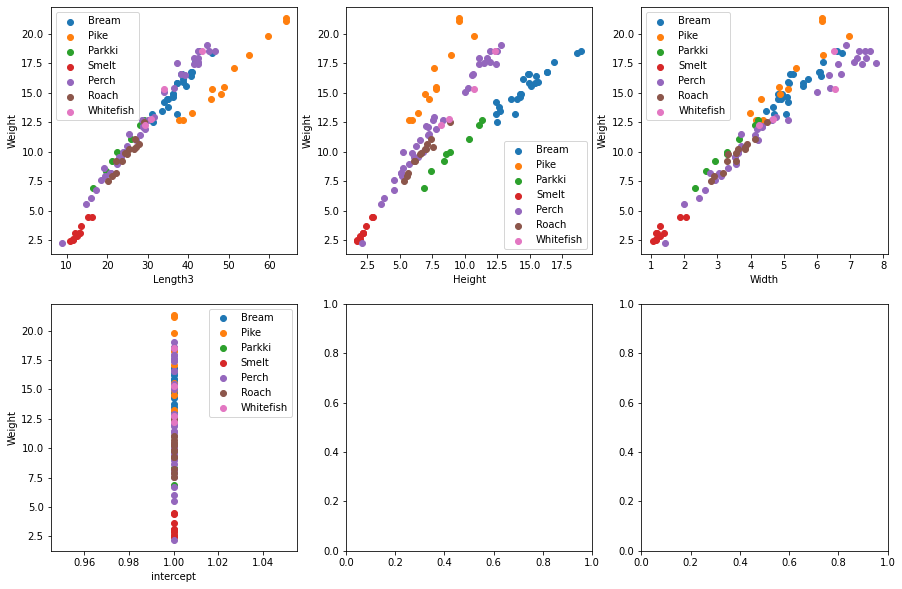

In [16]:
properties = {
    'y': "Weight",
    'category': "Species",
}

plot_data(data['train'], properties)

Implementacji OLS możemy łatwo dokonać w `numpy`/`torch` czy innej bibliotece/języku wspierającym operacje macierzowe. Możemy też skorzystać z gotowych rozwiązań, które przeważnie są wydajne i posiadają funkcjonalnośc pomocnicze.

Dwie podstawowe możliwości to:
- `LinearRegression` z `sklearn.linear_model`
- `OLS` z `statsmodels.regression.linear_model`
gdzie drugie rozwiązanie jest skierowane do statystyków (naśladuje `lm` z pakietu R), a pierwsze jest powszechnie wykorzystywane w świecie uczenia maszynowego. 

In [17]:
sklearn_model = LinearRegression(fit_intercept=False)
sklearn_model.fit(
    X=data['train'].drop(labels=['Weight', 'Species'], axis=1),
    y=data['train']['Weight'],
)
dict(zip(
    data['train'].drop(labels=['Weight', 'Species'], axis=1).columns,
    sklearn_model.coef_.tolist()
))

{'Length3': 0.18483490030385605,
 'Height': 0.18775048566468377,
 'Width': 1.1832504265417307,
 'intercept': -0.4234048957242274}

In [18]:
statsmodels_model = OLS(
    endog=data['train']['Weight'],
    exog=data['train'].drop(labels=['Weight', 'Species'], axis=1),
    hasconst=True
)
statsmodels_model_fitted = statsmodels_model.fit()
print(statsmodels_model_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2488.
Date:                Tue, 23 Mar 2021   Prob (F-statistic):           4.58e-98
Time:                        14:53:01   Log-Likelihood:                -90.873
No. Observations:                 110   AIC:                             189.7
Df Residuals:                     106   BIC:                             200.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Length3        0.1848      0.009     19.865      0.0

Obie biblioteki dają dokładnie te same wyniki, ponieważ OLS daje analityczne rozwiązanie.

## Zastosowanie modelu

Na danych treningowych

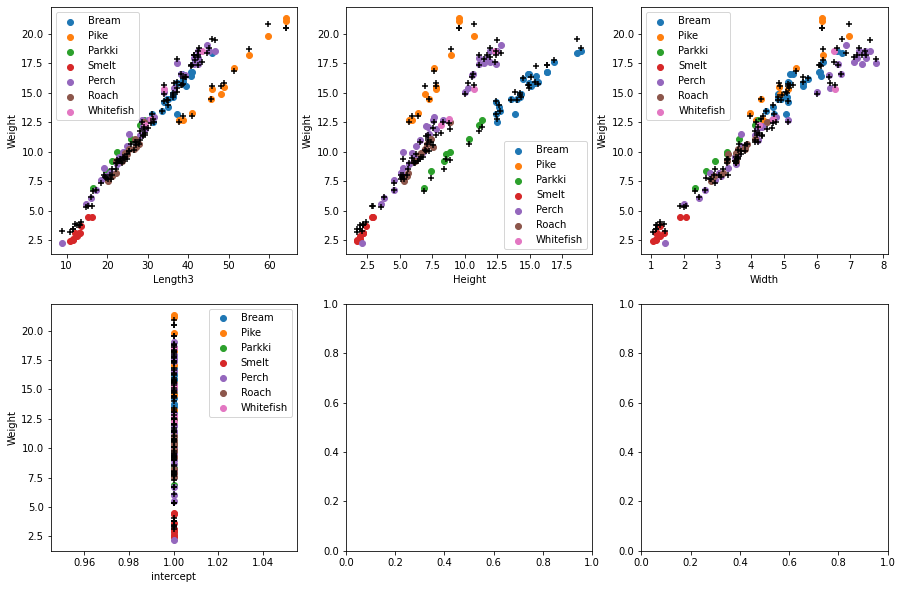

In [19]:
properties = {
    'y': "Weight",
    'category': "Species",
}

plot_data(
    data['train'],
    properties,
    regression_parameters=dict(zip(
        data['train'].drop(labels=['Weight', 'Species'], axis=1).columns,
        sklearn_model.coef_.tolist()
    ))
)

Na danych testowych

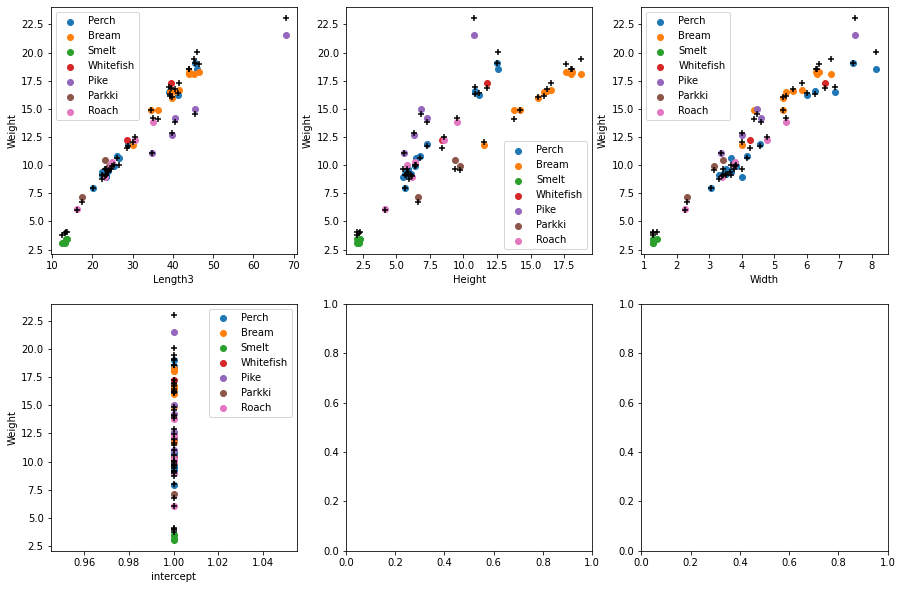

In [20]:
properties = {
    'y': "Weight",
    'category': "Species",
}

plot_data(
    data['test'],
    properties,
    regression_parameters=dict(zip(
        data['test'].drop(labels=['Weight', 'Species'], axis=1).columns,
        sklearn_model.coef_.tolist()
    ))
)

Sprawdźmy dopasowanie modelu na danych testowych

In [21]:
print("Średni błąd:", (
    (
        sklearn_model.predict(data['test'].drop(labels=['Weight', 'Species'], axis=1)) - 
        data['test']['Weight']
    )**2
).sum() / len(data['test']))

Średni błąd: 0.3111862127746904


Współczynnik determinacji $R^2$

In [22]:
print("Współczynnik determinacji R^2:", sklearn_model.score(
    data['test'].drop(labels=['Weight', 'Species'], axis=1),
    data['test']['Weight'],
))

Współczynnik determinacji R^2: 0.9849707240955344


# Przedziały ufności i przedziały predykcyjne

Z probabilistycznego punktu widzenia zadanie regresji polega na przewidzeniu wartości **ciągłej zmiennej losowej** warunkowanej pewnymi wartościami zmiennych niezależnych oraz danymi treningowymi. Prawdopodobieństwo trafienia w prawidłową wartość jest równe zero - wynika to z własności ciągłej dziedziny.

Regresja liniowa z OLS wprost wskazuje, że nie podejmuje próby predykcji prawidłowej wartości, a jedynie wartości oczekiwanej. Możemy także skorzystać z założeń metody i poza predykcjami punktowymi dokonać predykcji przedziałowych. Podejście to polega na określeniu pewnego **poziomu ufności** (najczęściej 95%), a następnie wyznaczeniu **przedziału ufność**, który obejmować będzie zadany przez poziom ufności procent rzeczywistych obserwacji. Pojawiają się dwa rodzaje przedziałów:
- Przedziały ufności (ang. *confidence intervals*)
   Ten rodzaj przedziału dotyczy najbardziej prawdopodobnego zakresu dla wartości oczekiwanej $Y$
   
   Średnia wartość odpowiedzi:
   $$ \hat{\bar{y}}_i = x_i \hat{\beta} $$
   Szerokość przedziału ufności:
   $$ \mathrm{Var}[\hat{\bar{y}}_i] =  \mathrm{Var}[x_i \hat{\beta}] = \sigma^2 x_i \left( X^\intercal X \right)^{-1}x_i^\intercal $$
   $$ \hat{y_i} \pm t_{n-p}^{\alpha / 2} \sigma \sqrt{x_i \left( X^\intercal X \right)^{-1}x_i^\intercal} $$

- Przedziały predykcyjne (ang. *prediction intervals*)
   Ten rodzaj przedziału dotyczy najbardziej prawdopodobnego zakresu dla faktycznej wartości $Y$, czyli jest szerszy od przedziału ufności na tym samym poziomie ufności.
   
   Wartość odpowiedzi:
   $$ \hat{y}_i = x_i \hat{\beta} + \epsilon_i $$
   Szerokość przedziału predykcyjnego:
   $$ \mathrm{Var}[\hat{y}_i] = \mathrm{Var}[x_i \hat{\beta} + \epsilon_i] = \mathrm{Var}[x_i \hat{\beta} + (y_i -  x_i \beta)] =  \mathrm{Var}[x_i \hat{\beta} + y_i] = \sigma^2 \left(x_i \left( X^\intercal X \right)^{-1}x_i^\intercal + 1\right) $$
   $$ \hat{y_i} \pm t_{n-p}^{\alpha / 2} \sigma \sqrt{x_i \left( X^\intercal X \right)^{-1}x_i^\intercal + 1} $$

In [23]:
ols_train, ols_test, beta, sigma = make_ols(
    x_train=data['train'].drop(labels=['Weight', 'Species'], axis=1),
    y_train=data['train']['Weight'],
    x_test=data['test'].drop(labels=['Weight', 'Species'], axis=1),
    alpha=0.05,
)

In [24]:
beta

{'Length3': 0.18483490030385546,
 'Height': 0.18775048566468344,
 'Width': 1.1832504265417259,
 'intercept': -0.42340489572424}

In [25]:
sigma

0.5630996797323913

In [26]:
print(data['train'].drop(labels=['Weight'], axis=1).columns)
print(data['test'].drop(labels=['Weight'], axis=1).columns)

Index(['Species', 'Length3', 'Height', 'Width', 'intercept'], dtype='object')
Index(['Species', 'Length3', 'Height', 'Width', 'intercept'], dtype='object')


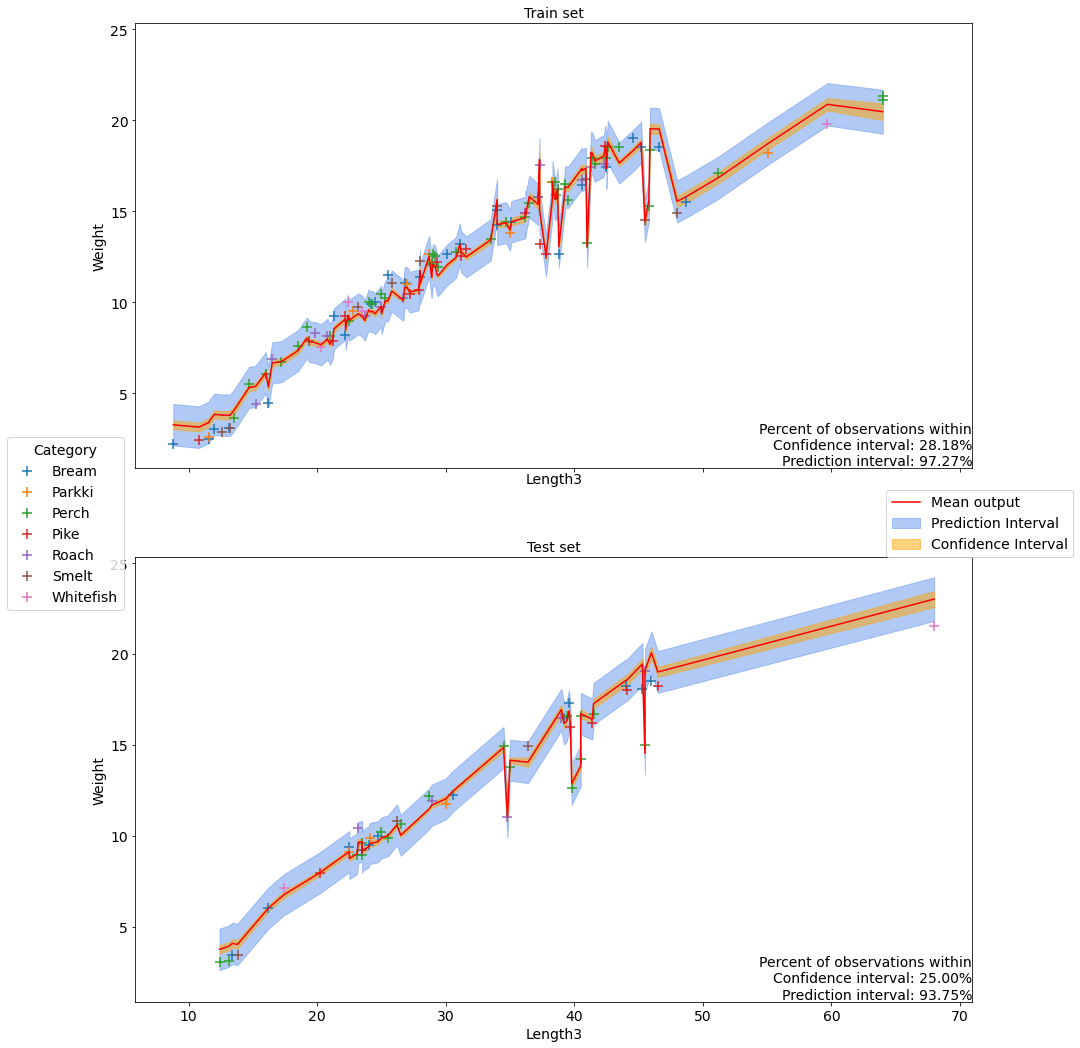

In [27]:
properties = {
    'x': 1,
    'x_label': "Length3",
    'y_label': "Weight",
    'category': 0,
}

plot_ols_data = {
    'Train': {
        'ols': ols_train,
        'x': data['train'].drop(labels=['Weight'], axis=1).to_numpy(),
        'y': data['train']['Weight'].to_numpy()
    },
    'Test': {
        'ols': ols_test,
        'x': data['test'].drop(labels=['Weight'], axis=1).to_numpy(),
        'y': data['test']['Weight'].to_numpy()
    }
}
   
plot_ols(plot_ols_data, properties)

### Co teraz zrobiłby statystyk?
1. Wykorzystał zmienną kategoryczną w modelu (zrobimy to w dalszej części)
2. Sprawdził, czy założenia są spełnione
3. Poszukał obserwacji **odstających** (ang. *outliers*), obserwacji o **high leverage** oraz obserwacji **wpływowych** (ang. *influential*) czyli odstających i high leverage.

   Te zagadnienia są istotne w teorii modeli liniowych. Zainteresowane osoby zapraszam do zapoznania się z *Agresti, A. (2015). Foundations Linear Generalized Linear Models (Recom GLM). In John Wiley & Sons.* rozdział *2.5  RESIDUALS, LEVERAGE, AND INFLUENCE*. W podsumowaniu rozdziału podane są dalsze źródła
4. Dla oczyszczonego, przekształconego by spełniał założenia zbioru danych przeprowadziłby analizę statystyczną modelu.

### Co teraz zrobiłby Data Scientist?
1. Wykorzystał zmienną kategoryczną w modelu (zrobimy to w dalszej części)
2. Zastosowałby **regularyzację** -> Ridge Regression, Lasso Regression, Elastic Net i inne

   Stosując regularyzację zrywamy z klasycznym, statystycznym dorobkiem dla modeli liniowych. W konsekwencji tracimy przedziały ufności, przedziały predykcyjne itp. Istnieją pewne wyprowadzenia dla szczególnych przypadków, ale nie są popularne.
   
   UWAGA: aby regularyzacja (zmuszanie parametrów by były bliskie zeru) miała sens należy dokonać **standaryzacji** zbioru danych!
   
   Zainteresowane osoby zapraszam do zapoznania się z *Bishop*, *Murphy* oraz *Tibshirani*.
   
   Odpowiedzią na "predykcję z ufnością" dla regularyzowanych modeli (dowolnych modeli predykcyjnych) jest **Conformal Prediction** - *Vovk, Vladimir, Alex Gammerman, and Glenn Shafer. Algorithmic learning in a random world. Springer Science & Business Media, 2005.*

### Co teraz zrobiłby entuzjasta Probabilistycznego Uczenia Maszynowego (czyli MY!)?
1. Wykorzystał zmienną kategoryczną w modelu (zrobimy to w dalszej części)
2. Z **estymacji punktowej** przeszedł na estymację **rozkładów parametrów**

   To podejście oznacza zaproponowanie rozkładów **prior** (sprzężony bądź nie-sprzężony; informatywny bądź nie-informatywny) dla wektora $\pmb{\beta}$ i zastosowanie podejścia Bayesowskiego do estymacji.
   
   Takie przedstawienie problemu jest w wielu aspektach równoważne **regularyzacji**, w przypadku modeli liniowych można to pokazać analitycznie - *Murphy*.